In [1]:
from pmap import *

In [2]:
import numpy as np

In [3]:
import pyresample

In [4]:
from mpl_toolkits.basemap import Basemap

In [5]:
import matplotlib.pyplot as plt 

In [6]:
import matplotlib

In [7]:
%matplotlib inline

In [8]:
def get_pop(wlat,wlon,wind,nan):
    filename='../../POPEXPO/lspop20141.tif' #population data filename
    #define the lat/lon window of wind swath
    minlon=wlon[wind != nan].min()
    maxlon=wlon[wind != nan].max()
    minlat=wlat[wind != nan].min()
    maxlat=wlat[wind != nan].max()
    buf=[minlon,maxlon,minlat,maxlat]
    
    pop=getmap(filename,buf) # read population data
    mpop=np.ma.masked_array(pop.data,pop.data==pop.nan) # mask the nan values
    
    mwind=np.ma.masked_array(wind,wind==nan) #mask the wind data for interpolation
    
    wgeo=pyresample.geometry.SwathDefinition(lons=wlon,lats=wlat) # the wind grid geometry
    pgeo=pyresample.geometry.SwathDefinition(lons=pop.lons,lats=pop.lats) # the pop grid geometry
    air_near=pyresample.kd_tree.resample_nearest(wgeo,np.flipud(mwind),pgeo,radius_of_influence=500000,fill_value=-999)
    
    reference = np.array([0,33,63,82,95,112,136,1000]) 
   # reference = np.array([0,20,33,49,50,58,1000]) 

    output_labels = ['TD', 'TS' ,'CAT. 1','CAT. 2' , 'CAT. 3', 'CAT. 4', 'CAT. 5'] #The value assigned to each interval
   # output_labels = ['', 'TS' ,'CAT. 1','CAT. 2' , 'CAT. 3', 'CAT. 4', 'CAT. 5'] #The value assigned to each interval

    sort_idx = np.argsort(reference) # saving the scale indeces 
    pos = np.searchsorted(reference[sort_idx], air_near, side = 'left') # sort the wind array
    out = np.argsort(reference)[pos] # restore the correct order of the scale, more info in http://stackoverflow.com/questions/31078160/classify-elements-of-a-numpy-array-using-a-second-array-as-reference
    
    dic={}
    for i in range(7):
        mask= out == i # wind force i
        try:
            npop = np.ma.masked_less(mpop[mask],0).sum() # sum of people exposed to wind force i
            if npop is np.ma.masked :
                dic[output_labels[i]] = 0 
            else:
                dic[output_labels[i]] = npop
        except Exception as e :
            print e
    return dic

In [9]:
wind=getmap('/mnt/pandora/Users_Critech/Brey/maptest/wind10mmalakas18w2016091600.tif')

In [10]:
wind

Bunch(CELLSIZE=0.04999999999999716, DRIVER='PCRaster Raster File', GeoTr=(106.75, 0.04999999999999716, 0.0, 53.1, 0.0, -0.04999999999999716), NCOLS=1225, NROWS=942, Proj='GEOGCS["GCS_WGS_1984",DATUM["WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]', XSTART=106.75, YSTART=53.1, data=array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ..., 
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]], dtype=float32), lats=[], lons=[], nan=-3.4028234663852886e+38)

In [11]:
# compute lat/lon
widthw=wind.NCOLS
heightw=wind.NROWS
gw=wind.GeoTr
wminx = gw[0]                                                                                                                            
wminy = gw[3] + widthw*gw[4] + heightw*gw[5]                                                                                               
wmaxx = gw[0] + widthw*gw[1] + heightw*gw[2]                                                                                               
wmaxy = gw[3]                                                                                                                            
                                                                                                                                          
wlon=np.linspace(wminx,wmaxx,widthw,endpoint=True)                                                                                          
wlat=np.linspace(wminy,wmaxy,heightw,endpoint=True)                                                                                         


In [12]:
w=np.flipud(wind.data)  # the issue of geotiff orientation

In [13]:
mwind=np.ma.masked_array(w,w==-999.)#wind.nan) # pay attention on the nan value

In [14]:
mwind.max()

121.22

In [15]:
# full window expand
minlon=wlon.min()
maxlon=wlon.max()
minlat=wlat.min()
maxlat=wlat.max()

In [16]:
minlon,maxlon,minlat,maxlat

(106.75, 167.99999999999653, 6.0000000000026787, 53.100000000000001)

In [17]:
xw,yw=np.meshgrid(wlon,wlat)

In [18]:
%%skip
# finite value window
minlon=xw[wind.data != -999.].min()
maxlon=xw[wind.data != -999.].max()
minlat=yw[wind.data != -999.].min()
maxlat=yw[wind.data != -999.].max()


In [19]:
parallels = np.arange(-90.,90,20.)                                                                                                        
meridians = np.arange(0.,360.,20.)                                                                                                        

In [20]:
m = Basemap(projection='cyl',llcrnrlat=minlat,urcrnrlat=maxlat, llcrnrlon=minlon,urcrnrlon=maxlon,resolution='l')    

{120.0: ([<matplotlib.lines.Line2D at 0x7fe144eda590>], []),
 140.0: ([<matplotlib.lines.Line2D at 0x7fe144edac10>], []),
 160.0: ([<matplotlib.lines.Line2D at 0x7fe144ee4290>], [])}

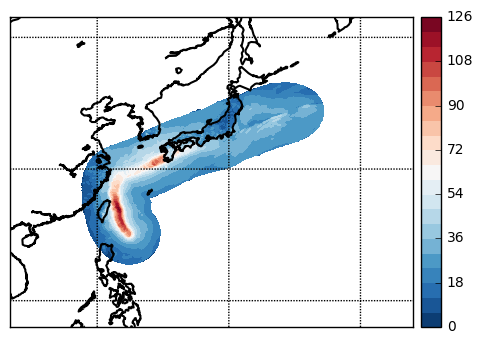

In [21]:
m.contourf(xw,yw,mwind,20,cmap=plt.cm.RdBu_r,animated=True)
m.colorbar()
m.drawcoastlines(linewidth=1.5)                                                                                                           
m.drawparallels(parallels)                                                                                                                
m.drawmeridians(meridians)    

## compute pop exposure

In [22]:
buf=[minlon,maxlon,minlat,maxlat]

In [23]:
buf

[106.75, 167.99999999999653, 6.0000000000026787, 53.100000000000001]

In [24]:
filename='../../POPEXPO/lspop20141.tif' #population data filename

In [25]:
pop=getmap(filename,buf) # read population data

In [26]:
pop

Bunch(CELLSIZE=0.0083333333333333, DRIVER='GeoTIFF', GeoTr=(106.74830435889606, 0.0083333333333333, 0.0, 53.089957868419276, 0.0, -0.0083333333333333), NCOLS=7351, NROWS=5651, Proj='GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]', XSTART=-180.0, YSTART=89.99999999999929, data=array([[          0,           0,           0, ..., -2147483647,
        -2147483647, -2147483647],
       [          0,           0,           0, ..., -2147483647,
        -2147483647, -2147483647],
       [          0,           0,           0, ..., -2147483647,
        -2147483647, -2147483647],
       ..., 
       [-2147483647, -2147483647, -2147483647, ..., -2147483647,
        -2147483647, -2147483647],
       [-2147483647, -2147483647, -2147483647, ..., -2147483647,
        -2147483647, -2147483647],
       [-2147483647, -2147483647, -2147483647, ...

In [27]:
mpop=np.ma.masked_array(pop.data,pop.data==pop.nan) # mask the nan values

In [28]:
mpop.shape

(5651, 7351)

In [29]:
wgeo=pyresample.geometry.SwathDefinition(lons=xw,lats=yw) # the wind grid geometry
pgeo=pyresample.geometry.SwathDefinition(lons=pop.lons,lats=pop.lats) # the pop grid geometry
air_near=pyresample.kd_tree.resample_nearest(wgeo,mwind,pgeo,radius_of_influence=500000,fill_value=wind.nan)


In [30]:
m = Basemap(projection='cyl',llcrnrlat=minlat,urcrnrlat=maxlat, llcrnrlon=minlon,urcrnrlon=maxlon,resolution='l')    

In [31]:
cmap = matplotlib.colors.ListedColormap(['w','b','g','y','r','purple']) # custom colormap

In [32]:
reference = np.array([0,33,63,82,95,112,136,1000]) # in kts

In [33]:
wlevs=[0,33,63,82,95,112,136,1000]

In [34]:
#reference = np.array([0,17,32,42,49,58,70,1000]) # in m/s

{120.0: ([<matplotlib.lines.Line2D at 0x7fe144d19450>], []),
 140.0: ([<matplotlib.lines.Line2D at 0x7fe144d19ad0>], []),
 160.0: ([<matplotlib.lines.Line2D at 0x7fe144d24150>], [])}

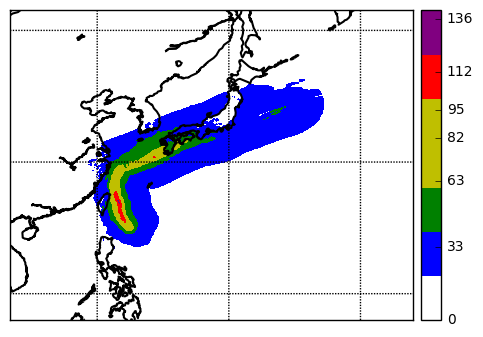

In [35]:
m.contourf(xw,yw,mwind,7,cmap=cmap,animated=True)
m.colorbar(ticks=reference)
m.drawcoastlines(linewidth=1.5)                                                                                                           
m.drawparallels(parallels)                                                                                                                
m.drawmeridians(meridians)    

In [36]:
#m.contourf(pop.lons,pop.lats,mpop,20,cmap=plt.cm.RdBu_r,animated=True)

In [37]:
output_labels = ['TD', 'TS' ,'CAT. 1','CAT. 2' , 'CAT. 3', 'CAT. 4', 'CAT. 5'] #The value assigned to each interval
sort_idx = np.argsort(reference) # saving the scale indeces 
pos = np.searchsorted(reference[sort_idx], air_near, side = 'left') # sort the wind array
out = np.argsort(reference)[pos] # restore the correct order of the scale, more info in http://stackoverflow.com/questions/31078160/classify-elements-of-a-numpy-array-using-a-second-array-as-reference

In [38]:
dic={}
for i in range(7):
        mask= out == i # wind force i
        try:
            npop = np.ma.masked_less(mpop[mask],0).sum() # sum of people exposed to wind force i
            if npop is np.ma.masked :
                dic[output_labels[i]] = 0 
            else:
                dic[output_labels[i]] = npop
        except Exception as e :
            print e


In [39]:
dic

{'CAT. 1': 21362937,
 'CAT. 2': 1066633,
 'CAT. 3': 15990,
 'CAT. 4': 636,
 'CAT. 5': 1009,
 'TD': 1198294253,
 'TS': 289599989}

In [40]:
exposure = get_pop(yw,xw,wind.data,-999.)

In [41]:
exposure

{'CAT. 1': 21362937,
 'CAT. 2': 1066633,
 'CAT. 3': 15990,
 'CAT. 4': 636,
 'CAT. 5': 1009,
 'TD': 250647429,
 'TS': 289596565}

In [42]:
#%%skip
resa=getmap('/mnt/web/brey/u10res.tif')

In [43]:
resa

Bunch(CELLSIZE=0.008333333333333, DRIVER='GeoTIFF', GeoTr=(106.75, 0.008333333333333, 0.0, 53.1, 0.0, -0.008333333333333), NCOLS=7350, NROWS=5652, Proj='', XSTART=106.75, YSTART=53.1, data=array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ..., 
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]], dtype=float32), lats=[], lons=[], nan=-3.4028234663852886e+38)

In [44]:
# compute lat/lon
widthw=resa.NCOLS
heightw=resa.NROWS
gw=resa.GeoTr
wminx = gw[0]                                                                                                                            
wminy = gw[3] + widthw*gw[4] + heightw*gw[5]                                                                                               
wmaxx = gw[0] + widthw*gw[1] + heightw*gw[2]                                                                                               
wmaxy = gw[3]                                                                                                                            
                                                                                                                                          
wlon=np.linspace(wminx,wmaxx,widthw,endpoint=True)                                                                                          
wlat=np.linspace(wminy,wmaxy,heightw,endpoint=True)                                                                                         


In [45]:
w=np.flipud(resa.data)  # the issue of geotiff orientation

In [46]:
mwind=np.ma.masked_array(w,w==-999.) # pay attention on the nan value

In [47]:
mwind.max()

121.22

In [48]:
# full window expand
minlon=wlon.min()
maxlon=wlon.max()
minlat=wlat.min()
maxlat=wlat.max()

In [49]:
xw,yw=np.meshgrid(wlon,wlat)

In [50]:
parallels = np.arange(-90.,90,20.)                                                                                                        
meridians = np.arange(0.,360.,20.)                                                                                                        

In [51]:
m = Basemap(projection='cyl',llcrnrlat=minlat,urcrnrlat=maxlat, llcrnrlon=minlon,urcrnrlon=maxlon,resolution='l')    

In [53]:
ti=np.arange(0.,mwind.max()+1) # custom range of colormap

In [41]:
color=['w','b','g','y','r','purple']

In [ ]:
cmap = matplotlib.colors.ListedColormap(color[:mwind.max()+1]) # custom colormap

{120.0: ([<matplotlib.lines.Line2D at 0x7fe144968850>], []),
 140.0: ([<matplotlib.lines.Line2D at 0x7fe1449448d0>], []),
 160.0: ([<matplotlib.lines.Line2D at 0x7fe144968e90>], [])}

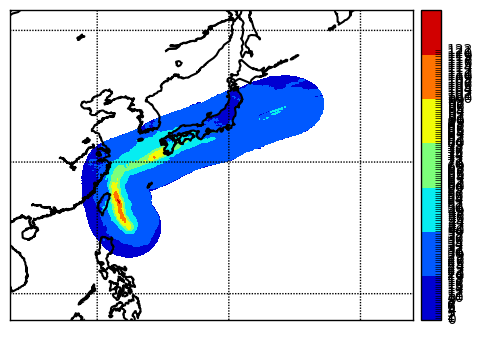

In [54]:
m.contourf(xw,yw,mwind)#,cmap=cmap,animated=True)
m.colorbar(ticks=ti)
m.drawcoastlines(linewidth=1.5)                                                                                                           
m.drawparallels(parallels)                                                                                                                
m.drawmeridians(meridians)    

In [55]:
 reference = np.array([0,33,63,82,95,112,136,1000]) # in kts

In [56]:
#reference = np.array([0,17,32,42,49,58,70,1000]) # in m/s

In [57]:
output_labels = ['TD', 'TS' ,'CAT. 1','CAT. 2' , 'CAT. 3', 'CAT. 4', 'CAT. 5'] #The value assigned to each interval
sort_idx = np.argsort(reference) # saving the scale indeces 
pos = np.searchsorted(reference[sort_idx], mwind, side = 'left') # sort the wind array
out = np.argsort(reference)[pos] # restore the correct order of the scale, more info in http://stackoverflow.com/questions/31078160/classify-elements-of-a-numpy-array-using-a-second-array-as-reference

In [58]:
out.max()

6

In [59]:
popc=getmap('/mnt/web/brey/lspop20141_clipped.tif')

In [60]:
popc.data.shape

(5652, 7350)

In [61]:
pop=np.flipud(popc.data)

In [62]:
pop.shape

(5652, 7350)

In [63]:
mwind.shape

(5652, 7350)

In [64]:
dic={}
for i in range(7):
        mask= out == i # wind force i
        try:
            npop = np.ma.masked_less(pop[mask],0).sum() # sum of people exposed to wind force i
            if npop is np.ma.masked :
                dic[output_labels[i]] = 0 
            else:
                dic[output_labels[i]] = npop
        except Exception as e :
            print e


In [65]:
dic

{'CAT. 1': 21166753,
 'CAT. 2': 1050101,
 'CAT. 3': 23213,
 'CAT. 4': 807,
 'CAT. 5': 838,
 'TD': 1198266138,
 'TS': 289275435}

In [ ]:
dic['TD']+dic['TS']

In [66]:
pop.shape

(5652, 7350)

In [67]:
mpop.shape

(5651, 7351)

In [68]:
[minlon,maxlon,minlat,maxlat]

[106.75, 167.99999999999756, 6.0000000000018829, 53.100000000000001]

In [69]:
buf

[106.75, 167.99999999999653, 6.0000000000026787, 53.100000000000001]